# Policies for Replicas and Thresholding for SVMs

Suppose we are given features $x$ such that $x_{ijk}$ is the $i$-th instance, $j$-th feature, and $k$-th replication of that instance and the corresponding class labels $y_i$. This notebook explores the following questions:

- How should the replicas be used? Averaged? As additional instances?
- Does thresholding (of feature values) increase classification accuracy?
- How should thresholding be used in combination with replicas?

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Experiment

- Ground truth feature values are taken from a hypergrid of density $D$ in each feature over the range $[-1, 1]$ such that there are $D$ evenly spaced points for each feature. As a result, there are $D^J$ feature values in the ground truth.
- Class values are assigned using the separating hyperplane $\sum_j x_j = 0$ applied to ground truth feature values. A class value of 1 is assigned if $\sum_j x_j > 0$ and -1 otherwise. The importance of a feature can be weighted by changing the separating hyperplane.
- The replications are obtained by adding noise from $N(0, \sigma^2)$ to each ground truth feature value.
- Accuracy is evaluated for feature vectors $\alpha (1, \cdots, 1)$ by computing average accuracy for a set $alpha$ and at different $\sigma^2$. The result of an experiment displays a plot of $\alpha \in [-\epsilon, \epsilon]$ versus accuracy at a value of $\sigma^2$.

## Creating the Grid

In [14]:
def makeGrid(density, dim, min_val=-1, max_val=1):
    """
    Creates a uniform grid on a space of arbitrary dimension.
    :param float density: points per unit
    """
    coords = [np.linspace(min_val, max_val, density*(max_val - min_val)) for _ in range(dim)]
    return np.meshgrid(*coords)

grid = makeGrid(5, 2)



In [23]:
np.reshape(grid[0], 100, 1)

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -0.77777778, -0.77777778, -0.77777778, -0.77777778, -0.77777778,
       -0.77777778, -0.77777778, -0.77777778, -0.77777778, -0.77777778,
       -0.55555556, -0.55555556, -0.55555556, -0.55555556, -0.55555556,
       -0.55555556, -0.55555556, -0.55555556, -0.55555556, -0.55555556,
       -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333,
       -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333,
       -0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111,
       -0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111,
        0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
        0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
        0.33333333,  0.33333333,  0.33333333,  0.33333333,  0.33333333,
        0.33333333,  0.33333333,  0.33333333,  0.33333333,  0.33

In [24]:
np.reshape(grid[1], 100, 1)

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ,
       -1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ,
       -1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ,
       -1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ,
       -1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ,
       -1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ,
       -1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.  

In [ ]:
# Reshape grid into a list of vectors
np.array()

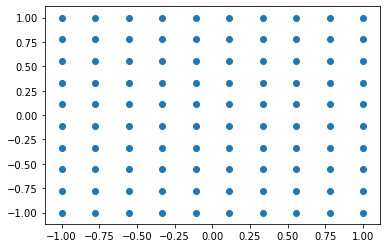

In [18]:
plt.scatter(grid[0], grid[1])

In [4]:
arr = np.array(range(12))
arr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [7]:
mat = np.reshape(arr, (2,3,2))
mat

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11]]])

In [9]:
np.reshape(mat, (6, 2))

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11]])

In [13]:
min_val = -1; max_val = 1; density = 2; num_dim = 3
coords = [np.linspace(min_val, max_val,
        density*(max_val - min_val))
        for _ in range(num_dim)]
grid = np.meshgrid(*coords)
grid

[array([[[-1.        , -1.        , -1.        , -1.        ],
         [-0.33333333, -0.33333333, -0.33333333, -0.33333333],
         [ 0.33333333,  0.33333333,  0.33333333,  0.33333333],
         [ 1.        ,  1.        ,  1.        ,  1.        ]],
 
        [[-1.        , -1.        , -1.        , -1.        ],
         [-0.33333333, -0.33333333, -0.33333333, -0.33333333],
         [ 0.33333333,  0.33333333,  0.33333333,  0.33333333],
         [ 1.        ,  1.        ,  1.        ,  1.        ]],
 
        [[-1.        , -1.        , -1.        , -1.        ],
         [-0.33333333, -0.33333333, -0.33333333, -0.33333333],
         [ 0.33333333,  0.33333333,  0.33333333,  0.33333333],
         [ 1.        ,  1.        ,  1.        ,  1.        ]],
 
        [[-1.        , -1.        , -1.        , -1.        ],
         [-0.33333333, -0.33333333, -0.33333333, -0.33333333],
         [ 0.33333333,  0.33333333,  0.33333333,  0.33333333],
         [ 1.        ,  1.        ,  1.       